In [1]:
import requests as r 
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np

#CLEANER LES 2 TABLES POUR GARDER COLONNES INTERESSANTES

## 1. Import datas & data cleaning

### Import data fertility from wikipedia

In [12]:
url='https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependencies_by_total_fertility_rate'
fertility=pd.read_html(url)
fert_tab=fertility[4][['Country','Fertility rate 2020 estimate (births/woman)']]

### Merge the 2 tables (fertility and happiness_202) on country

In [13]:
happy=pd.read_csv('C:/Users/auror/Project3_WorldHappiness/data/2020.CSV')
happy.rename(columns={'Country name':'Country'},inplace=True)
happy

,Country,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198
149,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445
150,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031
151,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,1.972317,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751


In [14]:
merge1=pd.merge(happy,fert_tab,on='Country')
merge1

,Country,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,...,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Fertility rate 2020 estimate (births/woman)
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,...,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.74
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,...,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,1.78
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,...,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,1.57
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,...,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,1.97
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,...,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,1.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,...,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,4.14
136,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,...,0.183541,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,3.52
137,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,...,0.810237,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,3.93
138,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,...,0.763417,1.972317,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,5.54


### Import and merge data about urbanization

In [15]:
url2='https://en.wikipedia.org/wiki/Urbanization_by_country'
urban=pd.read_html(url2)
urban_tab=urban[0][['Nation','Urban Population (%)']]
urban_tab.rename(columns={'Nation':'Country'},inplace=True)
urban_tab

C:\Users\auror\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Country,Urban Population (%)
0,Kuwait,100
1,Monaco,100
2,Nauru,100
3,Singapore,100
4,Vatican City,100
...,...,...
225,Papua New Guinea,13.3
226,Montserrat (UK),9.1
227,Pitcairn Islands (UK),0
228,Tokelau (New Zealand),0


In [16]:
merge2=pd.merge(merge1,urban_tab,on='Country')
merge2

,Country,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,...,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Fertility rate 2020 estimate (births/woman),Urban Population (%)
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,...,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.74,85.5
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,...,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,1.78,88.1
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,...,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,1.57,73.9
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,...,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,1.97,93.9
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,...,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,1.84,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,...,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,4.14,42.2
135,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,...,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,3.52,17.4
136,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,...,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,3.93,32.2
137,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,...,1.972317,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,5.54,20.2


### Import and merge data about sunshine_duration from wikipedia

In [18]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration'
html=r.get(url).content
soup=BeautifulSoup(html)

"""
1 table per continent, several rows per country(1row=1city), 
so concatenation of all the tables, group by country, with mean of sunshine duration 
"""

continent = ['africa', 'asia', 'europe','american','americas','oceania']
col=['Country', 'City', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Year', 'Ref.']
df_sunny=pd.DataFrame(columns=col)

for i in range(len(continent)):
    table=soup.select('table.sortable')[i]
    rows = table.find_all('tr')
    table =[[cell.strip() for cell in i.text.strip().split('\n') if cell!=''] for i in rows]
    df_sunny = pd.concat([df_sunny, pd.DataFrame(table[1:], columns=col)], ignore_index=True)
    
df_sunny['Year']=df_sunny['Year'].str.replace(',','')
df_sunny = df_sunny.astype({'Year': np.float64})
df_sunny = df_sunny.pivot_table(index=['Country'], values='Year', aggfunc='mean')



,Sunshine duration per Year
Country,
Afghanistan,3175.100000
Albania,2544.000000
Algeria,3266.500000
Angola,2341.000000
Argentina,2220.300000
...,...
Uzbekistan,2823.900000
Venezuela,2895.450000
Vietnam,2123.500000


In [22]:
df_sunny=df_sunny.rename(columns = {'Year': 'Sunshine duration per Year'})

In [23]:
merge3=pd.merge(merge2,df_sunny,on='Country', how='left')
merge3
#not to remove too much rows, merge is on left

,Country,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,...,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Fertility rate 2020 estimate (births/woman),Urban Population (%),Sunshine duration per Year
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,...,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.74,85.5,1858.000000
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,...,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,1.78,88.1,1568.000000
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,...,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,1.57,73.9,1566.000000
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,...,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,1.97,93.9,1326.000000
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,...,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,1.84,83,1373.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,...,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,4.14,42.2,2546.500000
135,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,...,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,3.52,17.4,NaN
136,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,...,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,3.93,32.2,3065.400000
137,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,...,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,5.54,20.2,2841.300000


### Data cleaning & Final dataframe

In [24]:
df=merge3[['Country','Regional indicator','Ladder score','Logged GDP per capita','Social support','Healthy life expectancy','Freedom to make life choices','Generosity','Perceptions of corruption','Explained by: Log GDP per capita','Explained by: Social support','Explained by: Healthy life expectancy','Explained by: Freedom to make life choices','Explained by: Generosity','Explained by: Perceptions of corruption','Dystopia + residual','Fertility rate 2020 estimate (births/woman)','Urban Population (%)','Sunshine duration per Year']]

In [25]:
df

,Country,Regional indicator,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Fertility rate 2020 estimate (births/woman),Urban Population (%),Sunshine duration per Year
0,Finland,Western Europe,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.74,85.5,1858.000000
1,Denmark,Western Europe,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,1.78,88.1,1568.000000
2,Switzerland,Western Europe,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,1.57,73.9,1566.000000
3,Iceland,Western Europe,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,1.97,93.9,1326.000000
4,Norway,Western Europe,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,1.84,83,1373.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Central African Republic,Sub-Saharan Africa,3.4759,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,4.14,42.2,2546.500000
135,Rwanda,Sub-Saharan Africa,3.3123,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,3.52,17.4,NaN
136,Zimbabwe,Sub-Saharan Africa,3.2992,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,3.93,32.2,3065.400000
137,South Sudan,Sub-Saharan Africa,2.8166,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,5.54,20.2,2841.300000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 138
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Country                                      139 non-null    object 
 1   Regional indicator                           139 non-null    object 
 2   Ladder score                                 139 non-null    float64
 3   Logged GDP per capita                        139 non-null    float64
 4   Social support                               139 non-null    float64
 5   Healthy life expectancy                      139 non-null    float64
 6   Freedom to make life choices                 139 non-null    float64
 7   Generosity                                   139 non-null    float64
 8   Perceptions of corruption                    139 non-null    float64
 9   Explained by: Log GDP per capita             139 non-null    float64
 10  Ex

In [27]:
df['Urban Population (%)'].unique()

array(['85.5', '88.1', '73.9', '93.9', '83', '92.2', '88', '86.7', '58.7',
       '91.5', '81.6', '86.2', '83.9', '92.6', '80.8', '63.7', '77.5',
       '82.7', '74.1', '98.1', '87', '94.7', '81', '80.7', '95.5', '84.3',
       '51.8', '71', '100', '87.1', '55.1', '73.4', '68.4', '53.8',
       '50.4', '87.7', '89.5', '68', '53.2', '60', '81.4', '66.8', '59',
       '56.4[2]', '40.8', '57.7', '69.2', '47.4', '71.9', '51.4', '92.1',
       '58.4', '68.3', '64.2', '66.3', '56.3', '91.8', '78.3', '56.4',
       '70.1', '37.2', '62.2', '82.5', '49', '42.8', '27.5', '67.5',
       '74.8', '36.9', '79.5', '79.7', '57.6', '68.7', '77.2', '37.3',
       '56.6', '48.4', '40.7', '57.3', '20.6', '76.1', '52.5', '75.7',
       '63.5', '88.3', '73.7', '48.1', '36.5', '16.6', '36.3', '62.1',
       '24.2', '38.2', '90.1', '67.4', '70.9', '88.9', '30.6', '43.9',
       '52', '63.3', '59.5', '75.9', '91.4', '37.1', '28', '69.6', '52.1',
       '25', '23.5', '55.3', '18.7', '29.4', '21.7', '38.5', '42.

In [28]:
#col 16 and 17 are object, to convert them one '[2]' had to be suppressed
df['Urban Population (%)']=df['Urban Population (%)'].str.replace("\[2\]", '')
df

C:\Users\auror\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,Regional indicator,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Fertility rate 2020 estimate (births/woman),Urban Population (%),Sunshine duration per Year
0,Finland,Western Europe,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.74,85.5,1858.000000
1,Denmark,Western Europe,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,1.78,88.1,1568.000000
2,Switzerland,Western Europe,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,1.57,73.9,1566.000000
3,Iceland,Western Europe,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,1.97,93.9,1326.000000
4,Norway,Western Europe,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,1.84,83,1373.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Central African Republic,Sub-Saharan Africa,3.4759,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,4.14,42.2,2546.500000
135,Rwanda,Sub-Saharan Africa,3.3123,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,3.52,17.4,NaN
136,Zimbabwe,Sub-Saharan Africa,3.2992,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,3.93,32.2,3065.400000
137,South Sudan,Sub-Saharan Africa,2.8166,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,5.54,20.2,2841.300000


In [31]:
#now we can convert on float all the number from the df
df = df.astype({'Fertility rate 2020 estimate (births/woman)': np.float64, 'Urban Population (%)': np.float64})
df

,Country,Regional indicator,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Fertility rate 2020 estimate (births/woman),Urban Population (%),Sunshine duration per Year,Rank
0,Finland,Western Europe,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.74,85.5,1858.000000,1
1,Denmark,Western Europe,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,1.78,88.1,1568.000000,2
2,Switzerland,Western Europe,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,1.57,73.9,1566.000000,3
3,Iceland,Western Europe,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,1.97,93.9,1326.000000,4
4,Norway,Western Europe,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,1.84,83.0,1373.333333,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Central African Republic,Sub-Saharan Africa,3.4759,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,4.14,42.2,2546.500000,135
135,Rwanda,Sub-Saharan Africa,3.3123,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,3.52,17.4,NaN,136
136,Zimbabwe,Sub-Saharan Africa,3.2992,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,3.93,32.2,3065.400000,137
137,South Sudan,Sub-Saharan Africa,2.8166,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,5.54,20.2,2841.300000,138


In [93]:
df['Sunshine duration per Year']= df['Sunshine duration per Year'].fillna('Not Applicable')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 138
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Country                                      139 non-null    object 
 1   Regional indicator                           139 non-null    object 
 2   Ladder score                                 139 non-null    float64
 3   Logged GDP per capita                        139 non-null    float64
 4   Social support                               139 non-null    float64
 5   Healthy life expectancy                      139 non-null    float64
 6   Freedom to make life choices                 139 non-null    float64
 7   Generosity                                   139 non-null    float64
 8   Perceptions of corruption                    139 non-null    float64
 9   Explained by: Log GDP per capita             139 non-null    float64
 10  Ex

In [95]:
df.to_csv('happi.csv', index=False)

## 2. Analyses on the dataframe

In [33]:
#to check all the correlation, add a column 'rank'
df['Rank']= df.index+1

In [34]:
df_corr = df.corr()
df_corr.applymap(lambda x: 'highly correlated' if (x>0.7) & (x!=1) else 'NA')

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Fertility rate 2020 estimate (births/woman),Urban Population (%),Sunshine duration per Year,Rank
Ladder score,NA,highly correlated,highly correlated,highly correlated,NA,NA,NA,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,NA,NA,NA,NA
Logged GDP per capita,highly correlated,NA,highly correlated,highly correlated,NA,NA,NA,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,NA,highly correlated,NA,NA
Social support,highly correlated,highly correlated,NA,highly correlated,NA,NA,NA,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,NA,NA,NA,NA
Healthy life expectancy,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,NA,NA,NA,NA
Freedom to make life choices,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,highly correlated,NA,NA,NA,NA,NA,NA,NA
Generosity,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,highly correlated,NA,NA,NA,NA,NA,NA
Perceptions of corruption,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Explained by: Log GDP per capita,highly correlated,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,highly correlated,highly correlated,NA,NA,NA,NA,NA,highly correlated,NA,NA
Explained by: Social support,highly correlated,highly correlated,highly correlated,highly correlated,NA,NA,NA,highly correlated,NA,highly correlated,NA,NA,NA,NA,NA,NA,NA,NA
Explained by: Healthy life expectancy,highly correlated,highly correlated,highly correlated,highly correlated,NA,NA,NA,highly correlated,highly correlated,NA,NA,NA,NA,NA,NA,NA,NA,NA


### cheking correlation between col and "explained by"

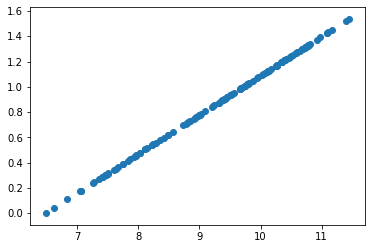

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.scatter(df['Logged GDP per capita'],df['Explained by: Log GDP per capita'])

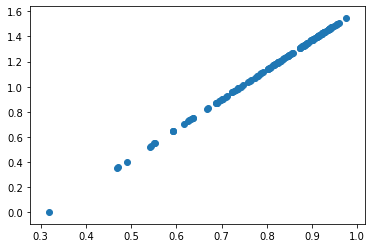

In [62]:
plt.scatter(df['Social support'],df['Explained by: Social support'])

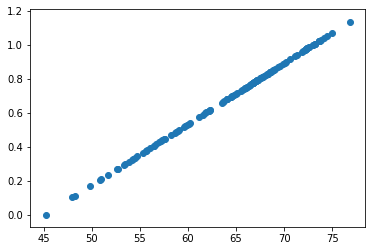

In [63]:
plt.scatter(df['Healthy life expectancy'],df['Explained by: Healthy life expectancy'])

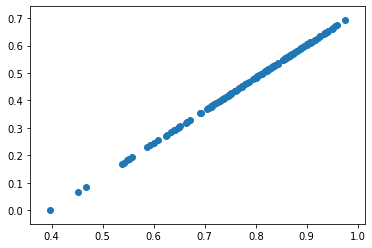

In [64]:
plt.scatter(df['Freedom to make life choices'],df['Explained by: Freedom to make life choices'])

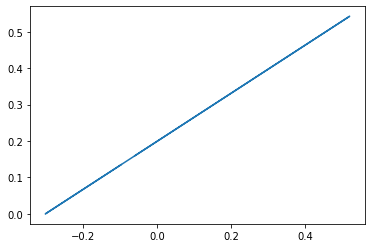

In [47]:
plt.plot(df['Generosity'],df['Explained by: Generosity'])

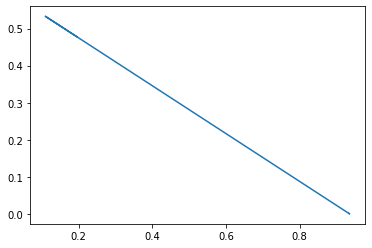

In [51]:
plt.plot(df['Perceptions of corruption'], df['Explained by: Perceptions of corruption'])

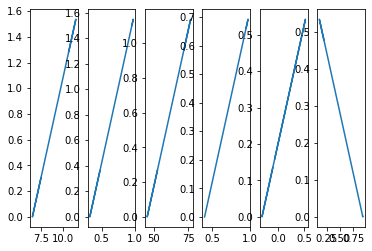

In [70]:
fig, axes=plt.subplots(1,6)

axes[0].plot(df['Logged GDP per capita'],df['Explained by: Log GDP per capita'], label='GDP')
axes[1].plot(df['Social support'],df['Explained by: Social support'], label='Social support')
axes[2].plot(df['Healthy life expectancy'],df['Explained by: Healthy life expectancy'], label='Healthy life expectancy')
axes[3].plot(df['Freedom to make life choices'],df['Explained by: Freedom to make life choices'], label='Freedom')
axes[4].plot(df['Generosity'],df['Explained by: Generosity'], label='Generosity')
axes[5].plot(df['Perceptions of corruption'], df['Explained by: Perceptions of corruption'], label='corruption')


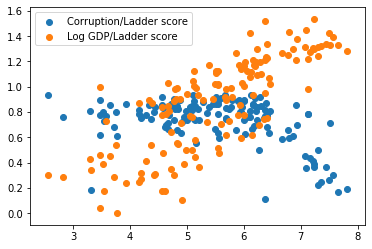

In [59]:
plt.scatter(df['Ladder score'], df['Perceptions of corruption'], label='Corruption/Ladder score')
plt.scatter(df['Ladder score'], df['Explained by: Log GDP per capita'], label='Log GDP/Ladder score')
plt.legend()

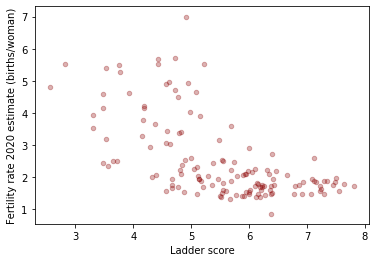

In [85]:
sns.regplot(x=df['Ladder score'], y=df['Fertility rate 2020 estimate (births/woman)'], fit_reg=False, scatter_kws={"color":"darkred","alpha":0.3,"s":20})

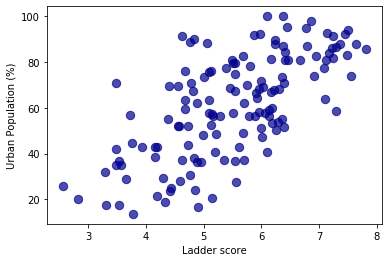

In [86]:
sns.regplot(x=df['Ladder score'], y=df['Urban Population (%)'], fit_reg=False, scatter_kws={"color":"darkblue","alpha":0.7,"s":70} )

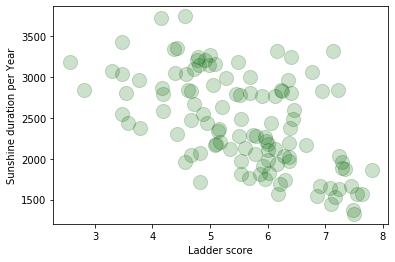

In [90]:
sns.regplot(x=df['Ladder score'], y=df['Sunshine duration per Year'], fit_reg=False, scatter_kws={"color":"darkgreen","alpha":0.2,"s":200} )

In [78]:
df.columns

Index(['Country', 'Regional indicator', 'Ladder score',
       'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Explained by: Log GDP per capita',
       'Explained by: Social support', 'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual', 'Fertility rate 2020 estimate (births/woman)',
       'Urban Population (%)', 'Sunshine duration per Year', 'Rank'],
      dtype='object')